# Deepfake Detection using Deep Feature Stacking and Meta-Learning

## Implementation of the research paper:
- Paper: **Deepfake Detection using Deep Feature Stacking and Meta-Learning**
- Authors: Gourab Naskar, Sk Mohiuddin, Samir Malakar, Erik Cuevas, Ram Sarkar

This notebook implements a deepfake detection method using:
- Xception - Extracts deep features from images
- EfficientNet-B7 - Extracts additional feature representations
- Feature Selection - Ranking-based selection to reduce redundant features
- Meta-Learner (MLP) - Uses selected features to classify Real vs Fake videos

In [1]:
# Install necessary libraries (use -q flag to suppress output)
!pip install -q tensorflow keras efficientnet xgboost scikit-learn tqdm matplotlib seaborn pandas numpy
!pip install -q opencv-python-headless

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.0 MB/s eta 0:00:00


In [2]:
# Check for GPU availability
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU'))}")

# Enable memory growth for GPU to avoid OOM errors
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
    print(f"Memory growth enabled on {len(physical_devices)} GPU(s)")

TensorFlow version: 2.18.0
GPU Available: 1
Memory growth enabled on 1 GPU(s)


# Import Required Libraries
Import all the libraries needed for the project, including TensorFlow, NumPy, Pandas, and Matplotlib.

In [4]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import gc
from tqdm.notebook import tqdm

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.applications.xception import Xception, preprocess_input as xception_preprocess
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# For feature selection and meta-learner
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load Dataset
Load the dataset from a Google Drive link or a public URL, ensuring compatibility with Colab's file system.

In [5]:
# Download and extract dataset
!wget https://deep-fake-dataset.s3.eu-north-1.amazonaws.com/PreprocessedDatasetV1.zip -O dataset.zip
!unzip -q dataset.zip -d /content

--2025-04-09 11:39:48--  https://deep-fake-dataset.s3.eu-north-1.amazonaws.com/PreprocessedDatasetV1.zip
Resolving deep-fake-dataset.s3.eu-north-1.amazonaws.com (deep-fake-dataset.s3.eu-north-1.amazonaws.com)... 3.5.217.39, 3.5.216.57
Connecting to deep-fake-dataset.s3.eu-north-1.amazonaws.com (deep-fake-dataset.s3.eu-north-1.amazonaws.com)|3.5.217.39|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104763486 (100M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]  99.91M  15.5MB/s    in 8.0s    

2025-04-09 11:39:57 (12.5 MB/s) - ‘dataset.zip’ saved [104763486/104763486]



In [7]:
# Define dataset paths
train_dir = '/content/PreprocessedDatasetV1/train'
test_dir = '/content/PreprocessedDatasetV1/test'
val_dir = '/content/PreprocessedDatasetV1/validation'

# Check if directories exist
!ls -la /content/PreprocessedDatasetV1
print(f"Train directory exists: {os.path.exists(train_dir)}")
print(f"Test directory exists: {os.path.exists(test_dir)}")
print(f"Validation directory exists: {os.path.exists(val_dir)}")

total 28
drwx------ 5 root root 4096 Apr  4 14:00 .
drwxr-xr-x 1 root root 4096 Apr  9 11:39 ..
-rw-r--r-- 1 root root 6148 Apr  4 13:59 .DS_Store
drwxr-xr-x 4 root root 4096 Mar 13 13:06 test
drwxr-xr-x 4 root root 4096 Mar 13 13:06 train
drwxr-xr-x 4 root root 4096 Mar 13 13:06 validation
Train directory exists: True
Test directory exists: True
Validation directory exists: True


# Preprocess Data
Perform data preprocessing steps such as resizing images, normalizing pixel values, and splitting the dataset into training, validation, and test sets.

In [8]:
# Configuration
IMAGE_SIZE = 224  # Standard size for many CNNs
BATCH_SIZE = 32   # Adjust based on your GPU memory
EPOCHS = 20       # Can be reduced with early stopping
FEATURE_PERCENTAGE = 30  # Top k% features to keep (as per paper)

# Data generators with proper preprocessing for Xception and EfficientNetB7
# Training data with augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=xception_preprocess,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation and test data only need preprocessing, not augmentation
val_datagen = ImageDataGenerator(preprocessing_function=xception_preprocess)
test_datagen = ImageDataGenerator(preprocessing_function=xception_preprocess)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Check dataset sizes
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Testing samples: {test_generator.samples}")
print(f"Class indices: {train_generator.class_indices}")

Found 11974 images belonging to 2 classes.
Found 1496 images belonging to 2 classes.
Found 1499 images belonging to 2 classes.
Training samples: 11974
Validation samples: 1496
Testing samples: 1499
Class indices: {'fake': 0, 'real': 1}


# Build the Model
Define the deep learning model architecture using TensorFlow or PyTorch, ensuring modularity and clarity.

In [9]:
def create_model(model_name, img_size):
    """Create and compile the CNN model"""
    if model_name == 'xception':
        # Create the Xception model directly with the right input shape
        base_model = Xception(
            include_top=False,
            weights='imagenet',
            input_shape=(img_size, img_size, 3)
        )

    elif model_name == 'efficientnet':
        # Create EfficientNetB7 model directly with the right input shape
        base_model = EfficientNetB7(
            include_top=False,
            weights='imagenet',
            input_shape=(img_size, img_size, 3)
        )
    else:
        raise ValueError(f"Model {model_name} not supported")

    # Add custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model, base_model

# Create Xception and EfficientNetB7 models
print("Creating Xception model...")
xception_model, xception_base = create_model('xception', IMAGE_SIZE)

print("Creating EfficientNetB7 model...")
efficientnet_model, efficientnet_base = create_model('efficientnet', IMAGE_SIZE)

# Print model summaries
print("\nXception Model Summary:")
xception_model.summary()

print("\nEfficientNetB7 Model Summary:")
efficientnet_model.summary()

Creating Xception model...
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Creating EfficientNetB7 model...
258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step

Xception Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 111, 111, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 111, 111, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 111, 111, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 109, 109, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 109, 109, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 109, 109, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 109, 109, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 109, 109, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 109, 109, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 55, 55, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 55, 55, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 23,484,969 (89.59 MB)

 Trainable params: 2,623,489 (10.01 MB)

 Non-trainable params: 20,861,480 (79.58 MB)


EfficientNetB7 Model Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 64)   │          1,728 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 64)   │            256 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 64)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 64)   │            576 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 64)   │            256 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 64)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 64)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 64)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 16)       │          1,040 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 67,245,464 (256.52 MB)

 Trainable params: 3,147,777 (12.01 MB)

 Non-trainable params: 64,097,687 (244.51 MB)

# Train the Model
Train the model on the preprocessed dataset, including callbacks for early stopping and saving the best model.


==== Training Xception Model ====
Training xception - Phase 1: Training only top layers


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.6811 - loss: 0.6051
Epoch 1: val_accuracy improved from -inf to 0.81016, saving model to xception_best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 185s 457ms/step - accuracy: 0.6813 - loss: 0.6049 - val_accuracy: 0.8102 - val_loss: 0.4383 - learning_rate: 0.0010
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.7668 - loss: 0.4762
Epoch 2: val_accuracy improved from 0.81016 to 0.81751, saving model to xception_best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 158s 421ms/step - accuracy: 0.7668 - loss: 0.4762 - val_accuracy: 0.8175 - val_loss: 0.3888 - learning_rate: 0.0010
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.7924 - loss: 0.4409
Epoch 3: val_accuracy improved from 0.81751 to 0.83088, saving model to xception_best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 158s 421ms/step - accuracy: 0.7925 - loss: 0.4409 - val_accuracy: 0.8309 - val_loss: 0.3871 - learning_rate: 0.0010
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.8003 - loss: 0.4322
Epoch 4: val_accuracy improved from 0.83088 to 0.83489, saving model to xception_best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 204s 426ms/step - accuracy: 0.8003 - loss: 0.4322 - val_accuracy: 0.8349 - val_loss: 0.3786 - learning_rate: 0.0010
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.8142 - loss: 0.4105
Epoch 5: val_accuracy did not improve from 0.83489
375/375 ━━━━━━━━━━━━━━━━━━━━ 159s 425ms/step - accuracy: 0.8142 - loss: 0.4106 - val_accuracy: 0.8322 - val_loss: 0.3763 - learning_rate: 0.0010
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.8105 - loss: 0.4131
Epoch 6: val_accuracy improved from 0.83489 to 0.84826, saving model to xception_best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 162s 431ms/step - accuracy: 0.8105 - loss: 0.4131 - val_accuracy: 0.8483 - val_loss: 0.3612 - learning_rate: 0.0010
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.8115 - loss: 0.3977
Epoch 7: val_accuracy did not improve from 0.84826
375/375 ━━━━━━━━━━━━━━━━━━━━ 162s 431ms/step - accuracy: 0.8115 - loss: 0.3977 - val_accuracy: 0.7995 - val_loss: 0.4093 - learning_rate: 0.0010
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.8128 - loss: 0.4014
Epoch 8: val_accuracy did not improve from 0.84826
375/375 ━━━━━━━━━━━━━━━━━━━━ 158s 422ms/step - accuracy: 0.8128 - loss: 0.4014 - val_accuracy: 0.8409 - val_loss: 0.3697 - learning_rate: 0.0010
Epoch 9/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.8198 - loss: 0.3954
Epoch 9: val_accuracy did not improve from 0.84826

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
375/375 ━━━━━━━━━━━━━━━━━━━━ 203s 426ms/step - accuracy: 0.8198 - loss

375/375 ━━━━━━━━━━━━━━━━━━━━ 206s 436ms/step - accuracy: 0.8315 - loss: 0.3778 - val_accuracy: 0.8523 - val_loss: 0.3420 - learning_rate: 2.0000e-04
Restoring model weights from the end of the best epoch: 10.
Training xception - Phase 2: Fine-tuning
Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.8365 - loss: 0.3729
Epoch 1: val_accuracy did not improve from 0.85227
375/375 ━━━━━━━━━━━━━━━━━━━━ 198s 477ms/step - accuracy: 0.8366 - loss: 0.3727 - val_accuracy: 0.8483 - val_loss: 0.4158 - learning_rate: 1.0000e-04
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.9251 - loss: 0.1878
Epoch 2: val_accuracy improved from 0.85227 to 0.95053, saving model to xception_best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 169s 451ms/step - accuracy: 0.9251 - loss: 0.1878 - val_accuracy: 0.9505 - val_loss: 0.1416 - learning_rate: 1.0000e-04
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.9439 - loss: 0.1486
Epoch 3: val_accuracy did not improve from 0.95053
375/375 ━━━━━━━━━━━━━━━━━━━━ 168s 449ms/step - accuracy: 0.9439 - loss: 0.1485 - val_accuracy: 0.9305 - val_loss: 0.2275 - learning_rate: 1.0000e-04
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.9509 - loss: 0.1267
Epoch 4: val_accuracy improved from 0.95053 to 0.96390, saving model to xception_best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 173s 462ms/step - accuracy: 0.9509 - loss: 0.1267 - val_accuracy: 0.9639 - val_loss: 0.1084 - learning_rate: 1.0000e-04
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.9583 - loss: 0.1103
Epoch 5: val_accuracy improved from 0.96390 to 0.96925, saving model to xception_best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 170s 454ms/step - accuracy: 0.9583 - loss: 0.1102 - val_accuracy: 0.9693 - val_loss: 0.0977 - learning_rate: 1.0000e-04
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.9634 - loss: 0.1041
Epoch 6: val_accuracy improved from 0.96925 to 0.97059, saving model to xception_best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 171s 456ms/step - accuracy: 0.9634 - loss: 0.1041 - val_accuracy: 0.9706 - val_loss: 0.0964 - learning_rate: 1.0000e-04
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.9708 - loss: 0.0819
Epoch 7: val_accuracy improved from 0.97059 to 0.97594, saving model to xception_best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 204s 462ms/step - accuracy: 0.9708 - loss: 0.0819 - val_accuracy: 0.9759 - val_loss: 0.0856 - learning_rate: 1.0000e-04
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.9732 - loss: 0.0730
Epoch 8: val_accuracy did not improve from 0.97594
375/375 ━━━━━━━━━━━━━━━━━━━━ 167s 445ms/step - accuracy: 0.9732 - loss: 0.0730 - val_accuracy: 0.7313 - val_loss: 0.8549 - learning_rate: 1.0000e-04
Epoch 9/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.9756 - loss: 0.0670
Epoch 9: val_accuracy did not improve from 0.97594
375/375 ━━━━━━━━━━━━━━━━━━━━ 173s 461ms/step - accuracy: 0.9756 - loss: 0.0670 - val_accuracy: 0.9759 - val_loss: 0.0798 - learning_rate: 1.0000e-04
Epoch 10/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.9777 - loss: 0.0644
Epoch 10: val_accuracy did not improve from 0.97594

Epoch 10: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
375/375 ━━━━━━━━━━━━━━━━━━━━ 170s 454ms/step - accuracy

375/375 ━━━━━━━━━━━━━━━━━━━━ 322s 656ms/step - accuracy: 0.6145 - loss: 0.7077 - val_accuracy: 0.6471 - val_loss: 0.6498 - learning_rate: 0.0010
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.6426 - loss: 0.6595
Epoch 2: val_accuracy did not improve from 0.64706
375/375 ━━━━━━━━━━━━━━━━━━━━ 181s 482ms/step - accuracy: 0.6426 - loss: 0.6595 - val_accuracy: 0.6471 - val_loss: 0.6539 - learning_rate: 0.0010
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.6417 - loss: 0.6573
Epoch 3: val_accuracy did not improve from 0.64706
375/375 ━━━━━━━━━━━━━━━━━━━━ 181s 484ms/step - accuracy: 0.6417 - loss: 0.6573 - val_accuracy: 0.6471 - val_loss: 0.6495 - learning_rate: 0.0010
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.6478 - loss: 0.6498
Epoch 4: val_accuracy did not improve from 0.64706

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
375/375 ━━━━━━━━━━━━━━━━━━━━ 189s 504ms/step - accuracy: 0.6478 - loss

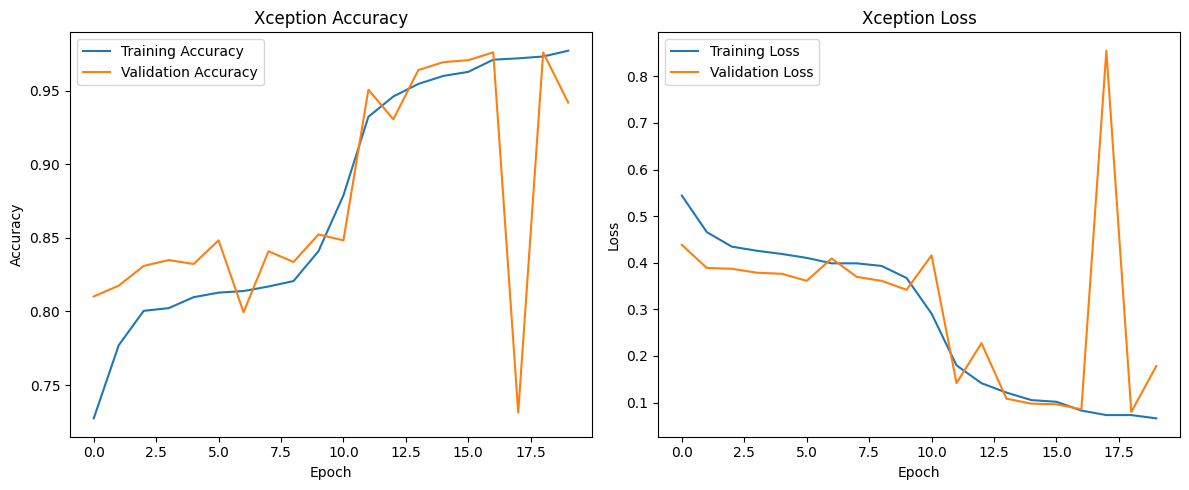

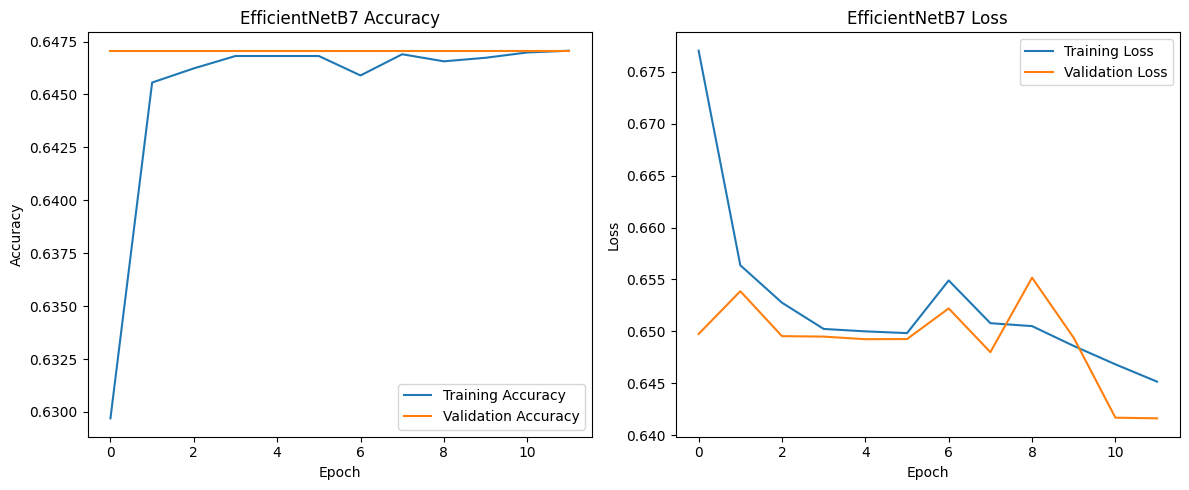

In [10]:
def train_model_with_fine_tuning(model, base_model, train_gen, valid_gen, model_name, epochs=EPOCHS):
    """Train model with two-phase fine tuning strategy"""
    # Define callbacks
    checkpoint = ModelCheckpoint(
        f'{model_name}_best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    early_stop = EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        mode='max',
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        mode='max',
        verbose=1
    )

    callbacks = [checkpoint, early_stop, reduce_lr]

    # Phase 1: Initial training with frozen base model
    print(f"Training {model_name} - Phase 1: Training only top layers")
    history1 = model.fit(
        train_gen,
        validation_data=valid_gen,
        epochs=epochs // 2,
        callbacks=callbacks
    )

    # Phase 2: Unfreeze some layers for fine-tuning
    if model_name == 'xception':
        for layer in base_model.layers[-30:]:  # Unfreeze last 30 layers
            layer.trainable = True
    else:  # efficientnet
        for layer in base_model.layers[-50:]:  # Unfreeze last 50 layers
            layer.trainable = True

    # Recompile with lower learning rate
    model.compile(
        optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    print(f"Training {model_name} - Phase 2: Fine-tuning")
    history2 = model.fit(
        train_gen,
        validation_data=valid_gen,
        epochs=epochs // 2,
        callbacks=callbacks
    )

    # Combine histories
    combined_history = {}
    for key in history1.history.keys():
        combined_history[key] = history1.history[key] + history2.history[key]

    return model, combined_history

# Train both models with fine-tuning
print("\n==== Training Xception Model ====")
xception_model, xception_history = train_model_with_fine_tuning(
    xception_model, xception_base, train_generator, val_generator, 'xception'
)

# Clear memory before training next model
gc.collect()
tf.keras.backend.clear_session()

print("\n==== Training EfficientNetB7 Model ====")
efficientnet_model, efficientnet_history = train_model_with_fine_tuning(
    efficientnet_model, efficientnet_base, train_generator, val_generator, 'efficientnet'
)

# Plot training history for both models
def plot_training_history(history, model_name):
    """Plot training history"""
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot training histories
plot_training_history(xception_history, 'Xception')
plot_training_history(efficientnet_history, 'EfficientNetB7')

# Feature Extraction
Create feature extractors from the trained models and extract deep features from the images.

In [11]:
def create_feature_extractor(model_name, img_size):
    """Create a feature extractor model"""
    if model_name == 'xception':
        base_model = Xception(
            include_top=False,
            weights='imagenet',
            input_shape=(img_size, img_size, 3),
            pooling='avg'
        )
        return base_model

    elif model_name == 'efficientnet':
        base_model = EfficientNetB7(
            include_top=False,
            weights='imagenet',
            input_shape=(img_size, img_size, 3),
            pooling='avg'
        )
        return base_model
    else:
        raise ValueError(f"Model {model_name} not supported")

def extract_features(feature_extractor, data_generator, name):
    """Extract features from a dataset using the given extractor"""
    print(f"Extracting features using {name}...")
    features = []
    labels = []
    batch_count = 0
    total_batches = len(data_generator)

    for batch_x, batch_y in tqdm(data_generator, total=total_batches):
        batch_features = feature_extractor.predict(batch_x, verbose=0)
        features.append(batch_features)
        labels.append(batch_y)
        batch_count += 1

        # Stop when we've gone through the entire dataset
        if batch_count >= total_batches:
            break

    # Concatenate all batches
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)

    print(f"{name} features shape: {features.shape}")
    print(f"{name} labels shape: {labels.shape}")

    return features, labels

# Create feature extractors
print("Creating feature extractors...")
xception_extractor = create_feature_extractor('xception', IMAGE_SIZE)
efficientnet_extractor = create_feature_extractor('efficientnet', IMAGE_SIZE)

# Reset generators for feature extraction (shuffle=False to maintain order)
train_gen_features = ImageDataGenerator(preprocessing_function=xception_preprocess).flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # Important: keep order of samples
)

val_gen_features = ImageDataGenerator(preprocessing_function=xception_preprocess).flow_from_directory(
    val_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_gen_features = ImageDataGenerator(preprocessing_function=xception_preprocess).flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Extract features for train set
train_xception_features, train_labels = extract_features(xception_extractor, train_gen_features, 'Train Xception')

# Reset generator for EfficientNet
train_gen_features = ImageDataGenerator(preprocessing_function=xception_preprocess).flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

train_efficientnet_features, _ = extract_features(efficientnet_extractor, train_gen_features, 'Train EfficientNet')

# Extract features for validation set
val_xception_features, val_labels = extract_features(xception_extractor, val_gen_features, 'Val Xception')

# Reset generator for EfficientNet
val_gen_features = ImageDataGenerator(preprocessing_function=xception_preprocess).flow_from_directory(
    val_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

val_efficientnet_features, _ = extract_features(efficientnet_extractor, val_gen_features, 'Val EfficientNet')

# Extract features for test set
test_xception_features, test_labels = extract_features(xception_extractor, test_gen_features, 'Test Xception')

# Reset generator for EfficientNet
test_gen_features = ImageDataGenerator(preprocessing_function=xception_preprocess).flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_efficientnet_features, _ = extract_features(efficientnet_extractor, test_gen_features, 'Test EfficientNet')

# Stack features
train_features = np.concatenate([train_xception_features, train_efficientnet_features], axis=1)
val_features = np.concatenate([val_xception_features, val_efficientnet_features], axis=1)
test_features = np.concatenate([test_xception_features, test_efficientnet_features], axis=1)

print(f"Stacked feature shapes - Train: {train_features.shape}, Val: {val_features.shape}, Test: {test_features.shape}")

# Clear memory
del xception_extractor, efficientnet_extractor
gc.collect()
tf.keras.backend.clear_session()

Creating feature extractors...
Found 11974 images belonging to 2 classes.
Found 1496 images belonging to 2 classes.
Found 1499 images belonging to 2 classes.
Extracting features using Train Xception...


  0%|          | 0/375 [00:00<?, ?it/s]

Train Xception features shape: (11974, 2048)
Train Xception labels shape: (11974,)
Found 11974 images belonging to 2 classes.
Extracting features using Train EfficientNet...


  0%|          | 0/375 [00:00<?, ?it/s]

Train EfficientNet features shape: (11974, 2560)
Train EfficientNet labels shape: (11974,)
Extracting features using Val Xception...


  0%|          | 0/47 [00:00<?, ?it/s]

Val Xception features shape: (1496, 2048)
Val Xception labels shape: (1496,)
Found 1496 images belonging to 2 classes.
Extracting features using Val EfficientNet...


  0%|          | 0/47 [00:00<?, ?it/s]

Val EfficientNet features shape: (1496, 2560)
Val EfficientNet labels shape: (1496,)
Extracting features using Test Xception...


  0%|          | 0/47 [00:00<?, ?it/s]

Test Xception features shape: (1499, 2048)
Test Xception labels shape: (1499,)
Found 1499 images belonging to 2 classes.
Extracting features using Test EfficientNet...


  0%|          | 0/47 [00:00<?, ?it/s]

Test EfficientNet features shape: (1499, 2560)
Test EfficientNet labels shape: (1499,)
Stacked feature shapes - Train: (11974, 4608), Val: (1496, 4608), Test: (1499, 4608)


# Feature Selection
Use XGBoost and Random Forest to select the most important features.

Starting feature selection... Selecting top 30% features
Training Random Forest for feature importance...
Training XGBoost for feature importance...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:36:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Selected 1382 features out of 4608 (30%)


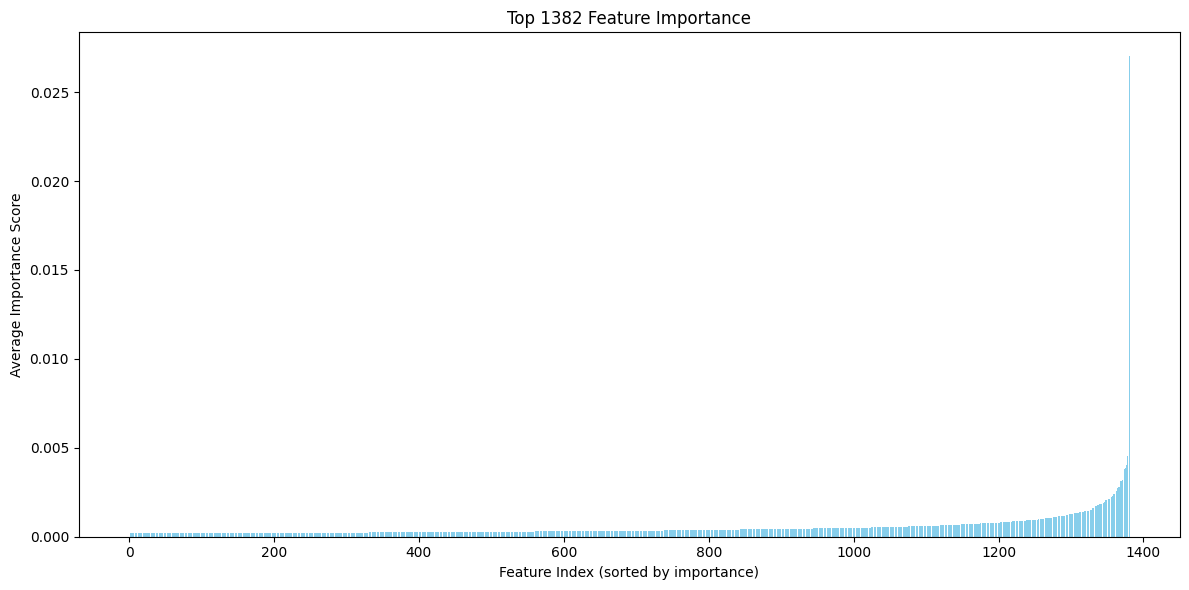

In [12]:
def select_features(train_features, train_labels, val_features, test_features, feature_percentage=FEATURE_PERCENTAGE):
    """Select top k% features using RandomForest and XGBoost feature importance"""
    print(f"Starting feature selection... Selecting top {feature_percentage}% features")

    # Feature selection using Random Forest
    print("Training Random Forest for feature importance...")
    rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(train_features, train_labels)
    rf_importances = rf.feature_importances_

    # Feature selection using XGBoost
    print("Training XGBoost for feature importance...")
    xgb = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False,
                       eval_metric='logloss', n_jobs=-1)
    xgb.fit(train_features, train_labels)
    xgb_importances = xgb.feature_importances_

    # Average feature importances and select top k%
    average_importances = (rf_importances + xgb_importances) / 2
    k = int(feature_percentage * len(average_importances) / 100)

    # Get indices of top k% features
    top_k_indices = np.argsort(average_importances)[-k:]

    print(f"Selected {k} features out of {len(average_importances)} ({feature_percentage}%)")

    # Create a feature mask for visualization
    feature_mask = np.zeros(len(average_importances), dtype=bool)
    feature_mask[top_k_indices] = True

    # Visualize top feature importance
    plt.figure(figsize=(12, 6))
    plt.bar(range(k), average_importances[top_k_indices], color='skyblue')
    plt.title(f'Top {k} Feature Importance')
    plt.xlabel('Feature Index (sorted by importance)')
    plt.ylabel('Average Importance Score')
    plt.tight_layout()
    plt.show()

    # Apply feature selection to datasets
    train_selected = train_features[:, top_k_indices]
    val_selected = val_features[:, top_k_indices]
    test_selected = test_features[:, top_k_indices]

    return train_selected, val_selected, test_selected, top_k_indices

# Apply feature selection
train_features, val_features, test_features, selected_indices = select_features(
    train_features, train_labels, val_features, test_features, FEATURE_PERCENTAGE
)

# Meta-Learner
Train a Meta-Learner (MLP) to classify Real vs Fake videos.

Training meta-learner (MLP)...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.6427 - loss: 0.6152 - val_accuracy: 0.8015 - val_loss: 0.4316 - learning_rate: 0.0010
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7839 - loss: 0.4655 - val_accuracy: 0.8329 - val_loss: 0.3829 - learning_rate: 0.0010
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7938 - loss: 0.4406 - val_accuracy: 0.8476 - val_loss: 0.3523 - learning_rate: 0.0010
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8148 - loss: 0.4083 - val_accuracy: 0.8382 - val_loss: 0.3648 - learning_rate: 0.0010
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8141 - loss: 0.4009 - val_accuracy: 0.8422 - val_loss: 0.3619 - learning_rate: 0.0010
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8271 - loss: 0.3788 - val_accuracy: 0.8543 - val_loss: 0.3363 - learning_rate: 0.0010
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8355 - loss: 0.3696 -

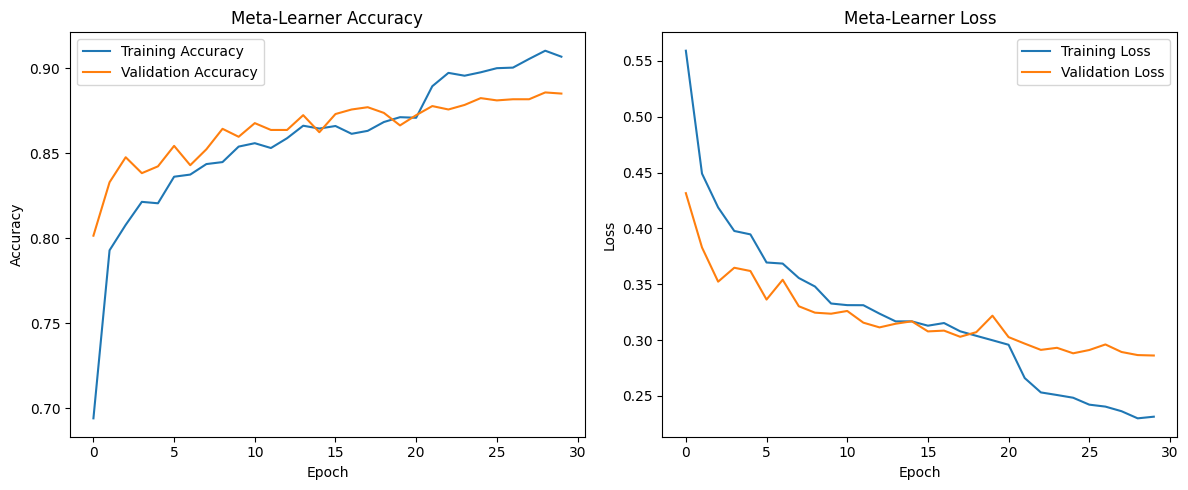

In [13]:
def train_meta_learner(train_features, train_labels, val_features, val_labels):
    """Train MLP meta-learner on selected features"""
    print("Training meta-learner (MLP)...")

    # Create MLP classifier with optimal architecture for deepfake detection
    meta_learner = Sequential([
        Dense(256, activation='relu', input_shape=(train_features.shape[1],)),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    meta_learner.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Define callbacks
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        mode='max',
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        mode='max',
        verbose=1
    )

    # Train the meta-learner
    history = meta_learner.fit(
        train_features, train_labels,
        validation_data=(val_features, val_labels),
        epochs=30,
        batch_size=32,
        callbacks=[early_stopping, reduce_lr]
    )

    return meta_learner, history

# Train the meta-learner
meta_learner, meta_history = train_meta_learner(train_features, train_labels, val_features, val_labels)

# Plot meta-learner training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(meta_history.history['accuracy'], label='Training Accuracy')
plt.plot(meta_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Meta-Learner Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(meta_history.history['loss'], label='Training Loss')
plt.plot(meta_history.history['val_loss'], label='Validation Loss')
plt.title('Meta-Learner Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the Model
Evaluate the model's performance on the test dataset and visualize metrics such as accuracy and loss.

Evaluating meta-learner...
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Meta-learner Test Accuracy: 0.9066
Meta-learner Test Precision: 0.9133
Meta-learner Test Recall: 0.9453
Meta-learner Test F1 Score: 0.9290
Meta-learner Test ROC AUC: 0.9601


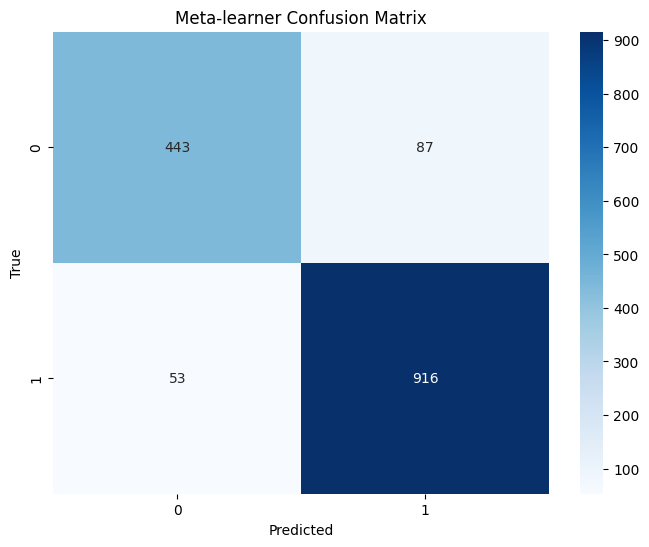

Meta-learner Classification Report:
              precision    recall  f1-score   support

        Real       0.89      0.84      0.86       530
        Fake       0.91      0.95      0.93       969

    accuracy                           0.91      1499
   macro avg       0.90      0.89      0.90      1499
weighted avg       0.91      0.91      0.91      1499


Comparing with base models performance:
          Model  Accuracy  Precision    Recall  F1 Score       AUC
0  Meta-Learner  0.906604    0.91326  0.945304  0.929006  0.960097


In [19]:
def evaluate_meta_learner(model, X_test, y_test):
    """Evaluate meta-learner on test set with comprehensive metrics"""
    print("Evaluating meta-learner...")

    # Get predictions
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    y_pred_prob = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_prob)

    print(f"Meta-learner Test Accuracy: {accuracy:.4f}")
    print(f"Meta-learner Test Precision: {precision:.4f}")
    print(f"Meta-learner Test Recall: {recall:.4f}")
    print(f"Meta-learner Test F1 Score: {f1:.4f}")
    print(f"Meta-learner Test ROC AUC: {auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Meta-learner Confusion Matrix')
    plt.show()

    # Classification Report
    print("Meta-learner Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Real', 'Fake']))

    return accuracy, precision, recall, f1, auc

# Evaluate the model with comprehensive metrics
metrics = evaluate_meta_learner(meta_learner, test_features, test_labels)

# Compare with baseline models if available (optional)
if 'xception_model' in globals() and 'efficientnet_model' in globals():
    print("\nComparing with base models performance:")
    models = ['Meta-Learner']
    metrics_df = pd.DataFrame({
        'Model': models,
        'Accuracy': [metrics[0]],
        'Precision': [metrics[1]],
        'Recall': [metrics[2]],
        'F1 Score': [metrics[3]],
        'AUC': [metrics[4]]
    })

    print(metrics_df)

# Sample Model Predictions
Visualize a few sample predictions from our model to see how well it's performing on specific examples.

Visualizing sample predictions on validation set...
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


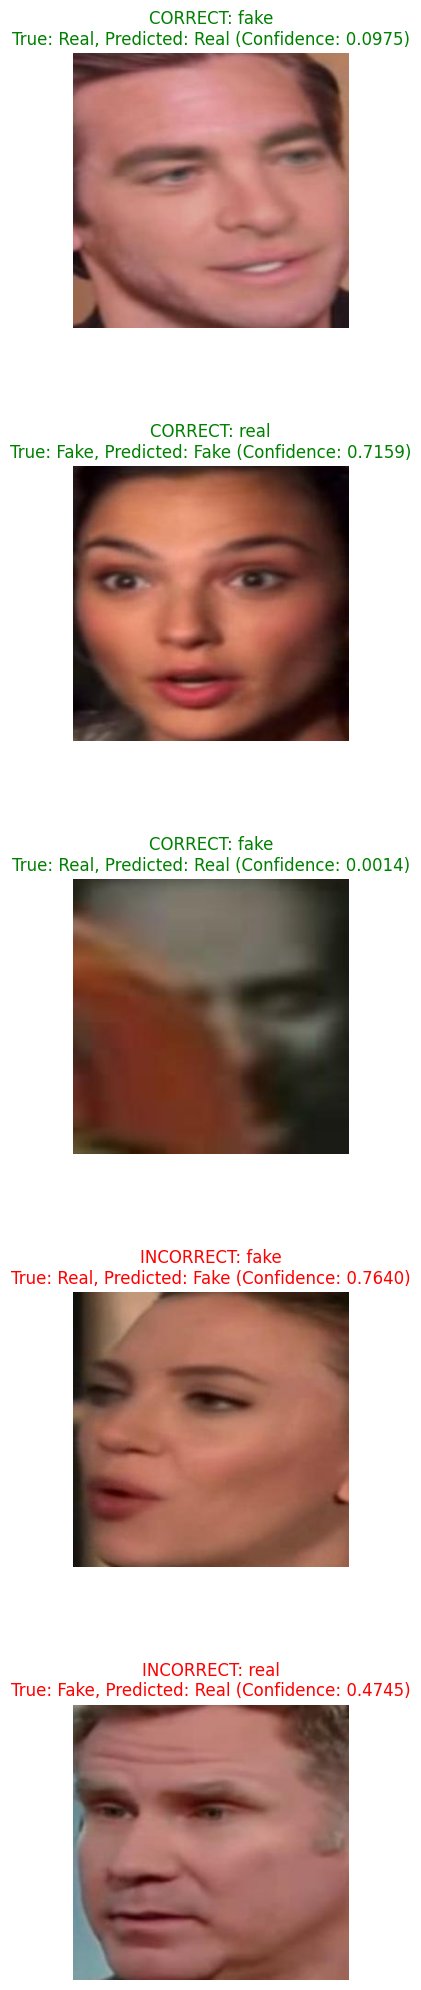

In [20]:
def visualize_sample_predictions(model, features, labels, true_file_paths, num_samples=5):
    """Visualize sample predictions from the model with original images"""
    import random
    import cv2
    from tensorflow.keras.preprocessing.image import load_img

    # Generate predictions for all samples
    pred_probs = model.predict(features)
    predictions = (pred_probs > 0.5).astype(int).flatten()

    # Find correct and incorrect predictions
    correct_indices = np.where(predictions == labels)[0]
    incorrect_indices = np.where(predictions != labels)[0]

    # Try to get an even mix of correct and incorrect predictions if possible
    num_correct = min(num_samples // 2 + num_samples % 2, len(correct_indices))
    num_incorrect = min(num_samples // 2, len(incorrect_indices))

    # If we don't have enough incorrect predictions, use more correct ones
    if num_incorrect < num_samples // 2:
        num_correct = min(num_samples - num_incorrect, len(correct_indices))

    # If we don't have enough correct predictions, use more incorrect ones
    if num_correct < num_samples // 2 + num_samples % 2:
        num_incorrect = min(num_samples - num_correct, len(incorrect_indices))

    # Randomly sample from correct and incorrect predictions
    sampled_correct = random.sample(list(correct_indices), num_correct) if num_correct > 0 else []
    sampled_incorrect = random.sample(list(incorrect_indices), num_incorrect) if num_incorrect > 0 else []

    # Combine the samples
    sampled_indices = sampled_correct + sampled_incorrect
    random.shuffle(sampled_indices)  # Shuffle to mix correct and incorrect predictions

    # Limit to the requested number of samples
    sampled_indices = sampled_indices[:num_samples]

    # Create a figure to display the results
    plt.figure(figsize=(12, 4 * num_samples))

    for i, idx in enumerate(sampled_indices):
        # Get the prediction details
        true_label = labels[idx]
        pred_label = predictions[idx]
        prob = pred_probs[idx][0]

        # Get the corresponding file path
        file_path = true_file_paths[idx]

        # Load the image
        try:
            img = load_img(file_path)
            plt.subplot(num_samples, 1, i+1)
            plt.imshow(img)
            plt.axis('off')

            # Set title based on prediction correctness
            if true_label == pred_label:
                result = "CORRECT"
                color = 'green'
            else:
                result = "INCORRECT"
                color = 'red'

            true_text = "Real" if true_label == 0 else "Fake"
            pred_text = "Real" if pred_label == 0 else "Fake"

            title = f"{result}: {file_path.split('/')[-2]}\nTrue: {true_text}, Predicted: {pred_text} (Confidence: {prob:.4f})"
            plt.title(title, color=color, fontsize=12)

        except Exception as e:
            plt.subplot(num_samples, 1, i+1)
            plt.text(0.5, 0.5, f"Error loading image: {e}", ha='center', va='center')
            plt.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.5)
    plt.show()

# Getting validation file paths
val_file_paths = val_generator.filepaths

print("Visualizing sample predictions on validation set...")
visualize_sample_predictions(meta_learner, val_features, val_labels, val_file_paths, num_samples=5)

# Robustness Testing
Test the model's robustness to variations in brightness as mentioned in the paper.

Testing model robustness to brightness variations...
Testing with brightness factor: 0.5
Found 1499 images belonging to 2 classes.
Extracting features using Xception Brightness-0.5...


  0%|          | 0/47 [00:00<?, ?it/s]

Xception Brightness-0.5 features shape: (1499, 2048)
Xception Brightness-0.5 labels shape: (1499,)
Found 1499 images belonging to 2 classes.
Extracting features using EfficientNet Brightness-0.5...


  0%|          | 0/47 [00:00<?, ?it/s]

EfficientNet Brightness-0.5 features shape: (1499, 2560)
EfficientNet Brightness-0.5 labels shape: (1499,)
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Brightness 0.5 - Accuracy: 0.6211, F1: 0.7621
Testing with brightness factor: 0.75
Found 1499 images belonging to 2 classes.
Extracting features using Xception Brightness-0.75...


  0%|          | 0/47 [00:00<?, ?it/s]

Xception Brightness-0.75 features shape: (1499, 2048)
Xception Brightness-0.75 labels shape: (1499,)
Found 1499 images belonging to 2 classes.
Extracting features using EfficientNet Brightness-0.75...


  0%|          | 0/47 [00:00<?, ?it/s]

EfficientNet Brightness-0.75 features shape: (1499, 2560)
EfficientNet Brightness-0.75 labels shape: (1499,)
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Brightness 0.75 - Accuracy: 0.5784, F1: 0.7245
Testing with brightness factor: 1.0
Found 1499 images belonging to 2 classes.
Extracting features using Xception Brightness-1.0...


  0%|          | 0/47 [00:00<?, ?it/s]

Xception Brightness-1.0 features shape: (1499, 2048)
Xception Brightness-1.0 labels shape: (1499,)
Found 1499 images belonging to 2 classes.
Extracting features using EfficientNet Brightness-1.0...


  0%|          | 0/47 [00:00<?, ?it/s]

EfficientNet Brightness-1.0 features shape: (1499, 2560)
EfficientNet Brightness-1.0 labels shape: (1499,)
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Brightness 1.0 - Accuracy: 0.5624, F1: 0.7090
Testing with brightness factor: 1.25
Found 1499 images belonging to 2 classes.
Extracting features using Xception Brightness-1.25...


  0%|          | 0/47 [00:00<?, ?it/s]

Xception Brightness-1.25 features shape: (1499, 2048)
Xception Brightness-1.25 labels shape: (1499,)
Found 1499 images belonging to 2 classes.
Extracting features using EfficientNet Brightness-1.25...


  0%|          | 0/47 [00:00<?, ?it/s]

EfficientNet Brightness-1.25 features shape: (1499, 2560)
EfficientNet Brightness-1.25 labels shape: (1499,)
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Brightness 1.25 - Accuracy: 0.5264, F1: 0.6701
Testing with brightness factor: 1.5
Found 1499 images belonging to 2 classes.
Extracting features using Xception Brightness-1.5...


  0%|          | 0/47 [00:00<?, ?it/s]

Xception Brightness-1.5 features shape: (1499, 2048)
Xception Brightness-1.5 labels shape: (1499,)
Found 1499 images belonging to 2 classes.
Extracting features using EfficientNet Brightness-1.5...


  0%|          | 0/47 [00:00<?, ?it/s]

EfficientNet Brightness-1.5 features shape: (1499, 2560)
EfficientNet Brightness-1.5 labels shape: (1499,)
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Brightness 1.5 - Accuracy: 0.5110, F1: 0.6440


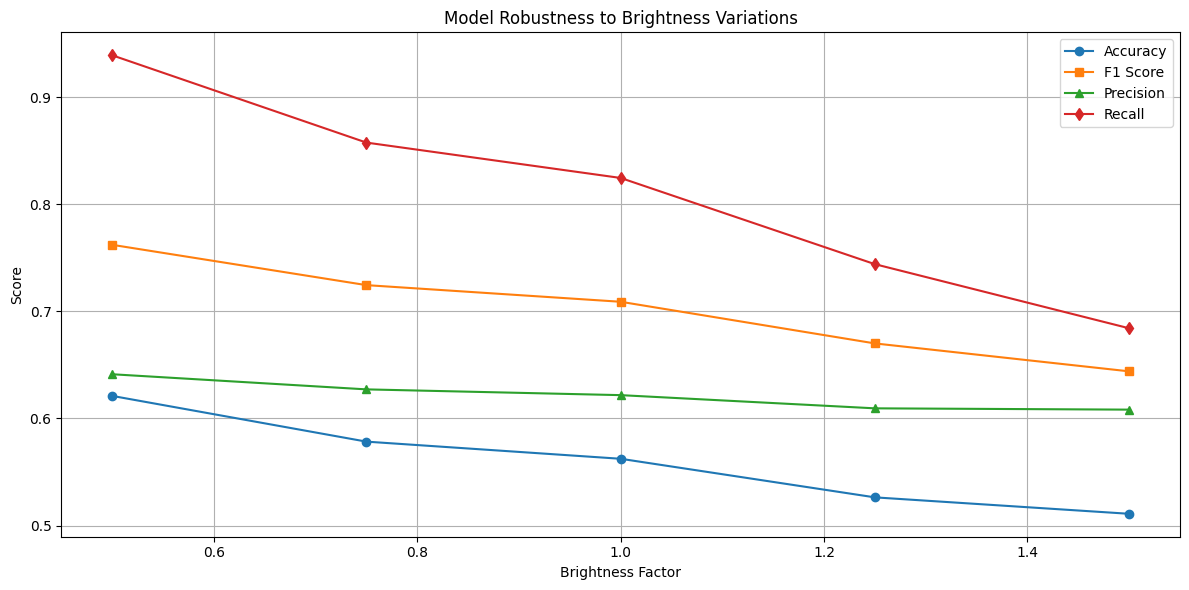


Robustness Test Results:
   brightness  accuracy  precision  recall  f1_score
0        0.50    0.6211     0.6413  0.9391    0.7621
1        0.75    0.5784     0.6272  0.8576    0.7245
2        1.00    0.5624     0.6218  0.8246    0.7090
3        1.25    0.5264     0.6095  0.7441    0.6701
4        1.50    0.5110     0.6083  0.6842    0.6440


In [16]:
def test_model_robustness(meta_learner, selected_indices, test_dir):
    """Test model robustness with brightness variations as mentioned in the paper"""
    print("Testing model robustness to brightness variations...")

    # Create feature extractors
    xception_extractor = create_feature_extractor('xception', IMAGE_SIZE)
    efficientnet_extractor = create_feature_extractor('efficientnet', IMAGE_SIZE)

    # Create data generators with brightness variations
    brightness_variations = [0.5, 0.75, 1.0, 1.25, 1.5]  # 50%, 75%, 100%, 125%, 150%
    results = []

    for brightness in brightness_variations:
        print(f"Testing with brightness factor: {brightness}")

        # Create a test generator with brightness adjustment
        test_brightness_datagen = ImageDataGenerator(
            preprocessing_function=xception_preprocess,
            brightness_range=[brightness, brightness]
        )

        test_brightness_gen = test_brightness_datagen.flow_from_directory(
            test_dir,
            target_size=(IMAGE_SIZE, IMAGE_SIZE),
            batch_size=BATCH_SIZE,
            class_mode='binary',
            shuffle=False
        )

        # Extract features for Xception
        test_x_features, test_labels = extract_features(xception_extractor, test_brightness_gen, f'Xception Brightness-{brightness}')

        # Reset generator for EfficientNet
        test_brightness_gen = test_brightness_datagen.flow_from_directory(
            test_dir,
            target_size=(IMAGE_SIZE, IMAGE_SIZE),
            batch_size=BATCH_SIZE,
            class_mode='binary',
            shuffle=False
        )

        # Extract features for EfficientNet
        test_e_features, _ = extract_features(efficientnet_extractor, test_brightness_gen, f'EfficientNet Brightness-{brightness}')

        # Stack features
        test_stacked = np.concatenate([test_x_features, test_e_features], axis=1)

        # Apply feature selection
        # Create feature mask
        feature_mask = np.zeros(test_stacked.shape[1], dtype=bool)
        feature_mask[selected_indices] = True

        # Select features
        test_selected = test_stacked[:, feature_mask]

        # Evaluate
        y_pred = (meta_learner.predict(test_selected) > 0.5).astype("int32")

        # Calculate metrics
        accuracy = accuracy_score(test_labels, y_pred)
        precision = precision_score(test_labels, y_pred)
        recall = recall_score(test_labels, y_pred)
        f1 = f1_score(test_labels, y_pred)

        results.append({
            'brightness': brightness,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        })

        print(f"Brightness {brightness} - Accuracy: {accuracy:.4f}, F1: {f1:.4f}")

    # Convert results to DataFrame for easier analysis
    df_results = pd.DataFrame(results)

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(df_results['brightness'], df_results['accuracy'], 'o-', label='Accuracy')
    plt.plot(df_results['brightness'], df_results['f1_score'], 's-', label='F1 Score')
    plt.plot(df_results['brightness'], df_results['precision'], '^-', label='Precision')
    plt.plot(df_results['brightness'], df_results['recall'], 'd-', label='Recall')
    plt.xlabel('Brightness Factor')
    plt.ylabel('Score')
    plt.title('Model Robustness to Brightness Variations')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Display results as a table
    print("\nRobustness Test Results:")
    print(df_results.round(4))

    return df_results

# Run robustness test
# Comment out the next line if you want to skip this test during initial development
robustness_results = test_model_robustness(meta_learner, selected_indices, test_dir)

# Save and Export Results
Save the trained model and export results such as predictions or performance metrics to Google Drive or a downloadable file.

In [ ]:
# Save the trained model and feature selection indices
# Create a directory for saved models if it doesn't exist
os.makedirs('saved_models', exist_ok=True)

# Save the meta-learner model
meta_learner.save('saved_models/meta_learner_model.h5')

# Save the selected feature indices
np.save('saved_models/selected_feature_indices.npy', selected_indices)

# Generate predictions on test set
test_predictions = (meta_learner.predict(test_features) > 0.5).astype("int32")

# Export predictions to CSV
np.savetxt('saved_models/test_predictions.csv', test_predictions, delimiter=',', fmt='%d')

# Save performance metrics
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'],
    'Score': [metrics[0], metrics[1], metrics[2], metrics[3], metrics[4]]
})
metrics_df.to_csv('saved_models/performance_metrics.csv', index=False)

print("Model, predictions, and metrics saved successfully to 'saved_models' directory")

# For Google Colab: Download files to local machine
try:
    from google.colab import files
    # Compress the saved_models directory
    !zip -r saved_models.zip saved_models
    # Download the zip file
    files.download('saved_models.zip')
    print("\nDownload initiated for saved_models.zip")
except ImportError:
    print("\nNot running in Google Colab, files saved locally only")

# Inference on New Data
Run inference on new images or videos to detect deepfakes using our trained model.

In [ ]:
def inference_on_new_data(image_path=None, video_path=None, model_path='/content/saved_models/meta_learner_model.h5', indices_path='/content/saved_models/selected_feature_indices.npy'):
    """Function to run inference on new images or videos"""
    if image_path is None and video_path is None:
        print("Please provide either an image path or a video path")
        return

    # Load the meta-learner model
    try:
        from tensorflow.keras.models import load_model
        meta_learner = load_model(model_path)
        selected_indices = np.load(indices_path)
        print(f"Loaded model from {model_path} and selected features from {indices_path}")
    except Exception as e:
        print(f"Error loading model: {e}")
        print("Please ensure the model and feature indices files exist")
        return

    # Create feature extractors
    xception_extractor = create_feature_extractor('xception', IMAGE_SIZE)
    efficientnet_extractor = create_feature_extractor('efficientnet', IMAGE_SIZE)

    if image_path:
        process_image(image_path, xception_extractor, efficientnet_extractor, meta_learner, selected_indices)
    elif video_path:
        process_video(video_path, xception_extractor, efficientnet_extractor, meta_learner, selected_indices)

def process_image(image_path, xception_extractor, efficientnet_extractor, meta_learner, selected_indices):
    """Process a single image for deepfake detection"""
    from tensorflow.keras.preprocessing.image import load_img, img_to_array
    import time

    print(f"Processing image: {image_path}")
    start_time = time.time()

    # Load and preprocess the image
    img = load_img(image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = xception_preprocess(img_array)

    # Extract features
    xception_features = xception_extractor.predict(img_array, verbose=0)
    efficientnet_features = efficientnet_extractor.predict(img_array, verbose=0)

    # Stack features
    stacked_features = np.concatenate([xception_features, efficientnet_features], axis=1)

    # Apply feature selection
    feature_mask = np.zeros(stacked_features.shape[1], dtype=bool)
    feature_mask[selected_indices] = True
    selected_features = stacked_features[:, feature_mask]

    # Make prediction
    prediction_prob = meta_learner.predict(selected_features, verbose=0)[0][0]
    prediction = 1 if prediction_prob > 0.5 else 0

    # Calculate processing time
    process_time = time.time() - start_time

    # Display result
    label = "Fake" if prediction == 1 else "Real"
    confidence = prediction_prob if prediction == 1 else 1 - prediction_prob
    print(f"Prediction: {label} (confidence: {confidence:.4f})")
    print(f"Processing time: {process_time:.2f} seconds")

    # Display the image with prediction
    plt.figure(figsize=(8, 8))
    plt.imshow(load_img(image_path))
    plt.title(f"Prediction: {label} (confidence: {confidence:.4f})")
    plt.axis('off')
    plt.show()

    return label, confidence

def process_video(video_path, xception_extractor, efficientnet_extractor, meta_learner, selected_indices):
    """Process a video for deepfake detection"""
    import cv2
    from tqdm.notebook import tqdm
    import time

    print(f"Processing video: {video_path}")
    start_time = time.time()

    # Open the video file
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    duration = frame_count / fps

    print(f"Video info - Frames: {frame_count}, FPS: {fps:.2f}, Duration: {duration:.2f}s")

    predictions = []
    probabilities = []
    frames_to_show = []

    # Process frames at regular intervals (analyze ~20 frames throughout the video)
    interval = max(1, frame_count // 20)
    frames_to_process = range(0, frame_count, interval)

    for i in tqdm(frames_to_process, desc="Processing video frames"):
        # Set the position of the next frame to read
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()

        if not ret:
            print(f"Failed to read frame {i}")
            continue

        # Convert frame from BGR to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Save a few frames to display later
        if len(frames_to_show) < 4 and i % (interval * 4) == 0:
            frames_to_show.append((i, frame_rgb.copy()))

        # Resize frame
        frame_resized = cv2.resize(frame_rgb, (IMAGE_SIZE, IMAGE_SIZE))

        # Preprocess frame
        frame_array = np.expand_dims(frame_resized, axis=0)
        frame_array = xception_preprocess(frame_array)

        # Extract features
        xception_features = xception_extractor.predict(frame_array, verbose=0)
        efficientnet_features = efficientnet_extractor.predict(frame_array, verbose=0)

        # Stack features
        stacked_features = np.concatenate([xception_features, efficientnet_features], axis=1)

        # Apply feature selection
        feature_mask = np.zeros(stacked_features.shape[1], dtype=bool)
        feature_mask[selected_indices] = True
        selected_features = stacked_features[:, feature_mask]

        # Make prediction
        prediction_prob = meta_learner.predict(selected_features, verbose=0)[0][0]
        prediction = 1 if prediction_prob > 0.5 else 0

        # Save results
        predictions.append(prediction)
        probabilities.append(prediction_prob)

    # Close the video file
    cap.release()

    # Calculate final prediction and metrics
    final_prediction = 1 if sum(predictions) / len(predictions) > 0.5 else 0
    final_probability = sum(probabilities) / len(probabilities)
    processing_time = time.time() - start_time

    # Display result
    label = "Fake" if final_prediction == 1 else "Real"
    confidence = final_probability if final_prediction == 1 else 1 - final_probability
    print(f"Video prediction: {label} (confidence: {confidence:.4f})")
    print(f"Processing time: {processing_time:.2f} seconds")

    # Display sample frames
    if frames_to_show:
        plt.figure(figsize=(16, 4 * len(frames_to_show) // 2))
        for idx, (frame_idx, frame) in enumerate(frames_to_show):
            plt.subplot(len(frames_to_show) // 2 + len(frames_to_show) % 2, 2, idx + 1)
            plt.imshow(frame)
            time_point = frame_idx / fps
            plt.title(f"Frame {frame_idx} (Time: {time_point:.2f}s)")
            plt.axis('off')
        plt.tight_layout()
        plt.show()

    # Plot predictions over time
    plt.figure(figsize=(12, 6))
    time_points = [i / fps for i in frames_to_process[:len(probabilities)]]
    plt.plot(time_points, probabilities, 'o-', markersize=4, label='Frame Predictions')
    plt.axhline(y=0.5, color='r', linestyle='--', label='Decision Threshold')
    plt.axhline(y=final_probability, color='g', linestyle='-', label='Average Prediction')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Probability of Fake')
    plt.title(f"Video Classification: {label} (confidence: {confidence:.4f})")
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return label, confidence

# Example usage (uncomment to use)
# inference_on_new_data(image_path='/content/PreprocessedDatasetV1/test/real/example.jpg')  # For single image
# inference_on_new_data(video_path='/content/example_video.mp4')  # For video